# Exploring a toy model of finetuning

This notebook implements toy Transformers architecture, and LoRA algorithm in a toy setting which is modular addition and subtraction.


*  We first train a toy model Transformers on modular addition.
*  We then fine-tune this model to make it learn modular addition with LoRA algorithm.

The objectives are to show how much deepth is needed to make the finetuning LoRA learn this new task




First, let us notice that the modular addition and modular subtraction are disjoint tasks because $$x+y\equiv x-y \mod p \iff 2y \equiv 0 \mod p. $$
Here, we have chosen $p$ which is a prime number larger than $3$ so $2$ is invertible in the ring $\mathbb{Z}/113\mathbb{Z}$. It leads us to state that  $$x+y\equiv x-y \mod p \iff y \equiv 0 \mod p. $$
So, learning modular subtraction is not just implied a priori by modular addition.

# Transformer with 1 layer (Training and Fine-Tuning)  


## Model declaration

### Imports

In [123]:
!pip install peft

In [124]:
!nvidia-smi

Thu Jan 25 13:48:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              31W /  70W |   1143MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [125]:
!pip install seaborn

In [126]:
!pip install einops

In [127]:
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from tqdm.auto import tqdm
import math
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

import peft
import copy

In [128]:
 Z=sns.color_palette("Paired")

### Transformer implementation

In [129]:
alpha=1
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(alpha*torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))

    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(alpha*torch.randn(max_ctx, d_model)/np.sqrt(d_model))

    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(alpha*torch.ones(d_model))
        self.b_ln = nn.Parameter(alpha*torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Linear(d_head, d_model)
        self.W_Q = nn.Linear(d_head, d_model)
        self.W_V = nn.Linear(d_head, d_model)
        self.W_O = nn.Linear(d_model, d_head )
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head

    def forward(self, x):
      ###computation of the scalar products
        W_k=self.W_K.weight
        W_q=self.W_Q.weight
        W_v=self.W_V.weight
        W_o=self.W_O.weight
        k =torch.einsum('hd,bpd->bph', W_k, x)
        q = torch.einsum('hd,bpd->bph',W_q, x)
        v = torch.einsum('hd,bpd->bph', W_v, x)
        attn_scores_pre = torch.einsum('bph,bqh->bqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = F.softmax((attn_scores_masked/np.sqrt(self.d_head)), dim=-1)
        z = torch.einsum('bph,bqp->bqh', v, attn_matrix)
        z_flat = einops.rearrange(z, 'b q h -> b q (h)')
        out = torch.einsum('df,bqf->bqd', W_o, z_flat)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model    #512 dim
        self.num_heads = num_heads   #8
        self.single_head_dim = int(self.d_model / self.num_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.num_heads*self.single_head_dim ,self.d_model)

    def forward(self,x,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size = x.size(0)
        seq_length = x.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        #seq_length_query = query.size(1)

        # 32x10x512
        key = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)
        value = x.view(batch_size, seq_length, self.num_heads, self.single_head_dim) #(32x10x8x64)

        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))
        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim)
        #applying softmax
        scores = F.softmax(product, dim=-1)
        #mutiply with value matrix
        scores = torch.matmul(scores, v)
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length, self.single_head_dim*self.num_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)

        output = self.out(concat) #(32,10,512) -> (32,10,512)

        return output
# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(alpha*torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(alpha*torch.zeros(d_mlp))
        self.W_out = nn.Parameter(alpha*torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        self.ln = LayerNorm(d_mlp, model=self.model)
        assert act_type in ['ReLU', 'GeLU']

    def forward(self, x):
        x = torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = MultiHeadAttention(d_model, num_heads, d_head, n_ctx, model=self.model)
        self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type,use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache
        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        #for name, module in self.named_modules():
            #if type(module)==HookPoint:
             #   module.give_name(name)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        x = self.unembed(x)
        ##mettre un pooling

        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache


### Baseline training run

In [130]:
def full_loss(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    return torch.nn.functional.cross_entropy(logits, labels)

def full_accuracy(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    predictions = torch.argmax(logits, dim=1)
    return torch.sum(predictions == labels).item() / len(labels)

### Data

In [ ]:
seed = 72
p = 113
fraction = 0.3
equals_token= p

In [ ]:
device='cuda'

In [ ]:
equals_token = p
fraction=0.3
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
plus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+1)
prompts = torch.stack([x, plus, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])


### Model

In [ ]:
model = Transformer(num_layers=1,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                ).to(device)

## Training loop for modular addition

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=300, threshold=10e-8,verbose=True)
log_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
test_minus= []
norms = []
for epoch in tqdm(range(15000)):
  train_loss = full_loss(model, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
    with torch.no_grad():
          log_steps.append(epoch)
          test_loss = full_loss(model, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses.append(train_loss.item())
          test_losses.append(test_loss.item())
          train_accuracies.append(full_accuracy(model, train, device))
          test_accuracies.append(full_accuracy(model, test, device))
          norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f |  l2: %.6f"%(epoch, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1], norms[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()



  0%|          | 0/15000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.135991 |  Test loss: 5.140759 | train_acc: 0.01 | test_acc: 0.01 |  l2: 48.341234
epoch: 30  | Train loss: 4.639607 |  Test loss: 4.801790 | train_acc: 0.03 | test_acc: 0.00 |  l2: 47.738736
epoch: 60  | Train loss: 3.966515 |  Test loss: 5.650352 | train_acc: 0.14 | test_acc: 0.01 |  l2: 47.991354
epoch: 90  | Train loss: 2.799577 |  Test loss: 5.638716 | train_acc: 0.44 | test_acc: 0.05 |  l2: 48.681006
epoch: 120  | Train loss: 1.423998 |  Test loss: 5.396102 | train_acc: 0.81 | test_acc: 0.20 |  l2: 49.687800
epoch: 150  | Train loss: 0.589383 |  Test loss: 5.298648 | train_acc: 0.99 | test_acc: 0.28 |  l2: 50.326447
epoch: 180  | Train loss: 0.236756 |  Test loss: 5.317831 | train_acc: 1.00 | test_acc: 0.30 |  l2: 50.620684
epoch: 210  | Train loss: 0.121269 |  Test loss: 5.342171 | train_acc: 1.00 | test_acc: 0.30 |  l2: 50.597944
epoch: 240  | Train loss: 0.078338 |  Test loss: 5.336880 | train_acc: 1.00 | test_acc: 0.30 |  l2: 50.408926
epoch: 270  | T

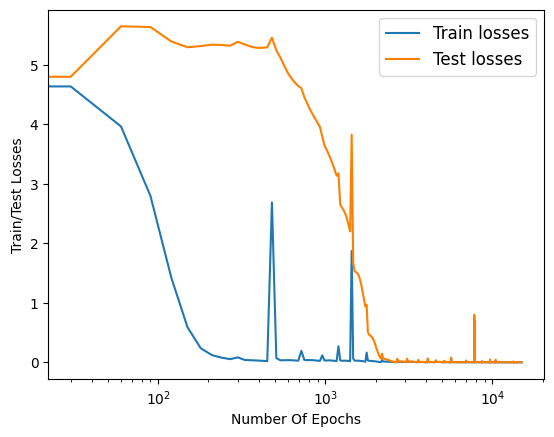

In [ ]:
plt.figure
plt.plot(log_steps,train_losses, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

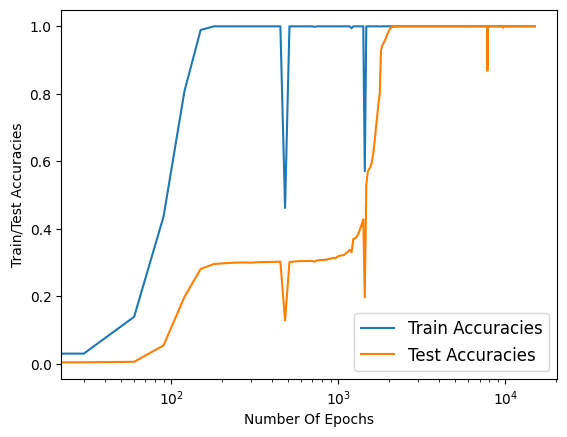

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

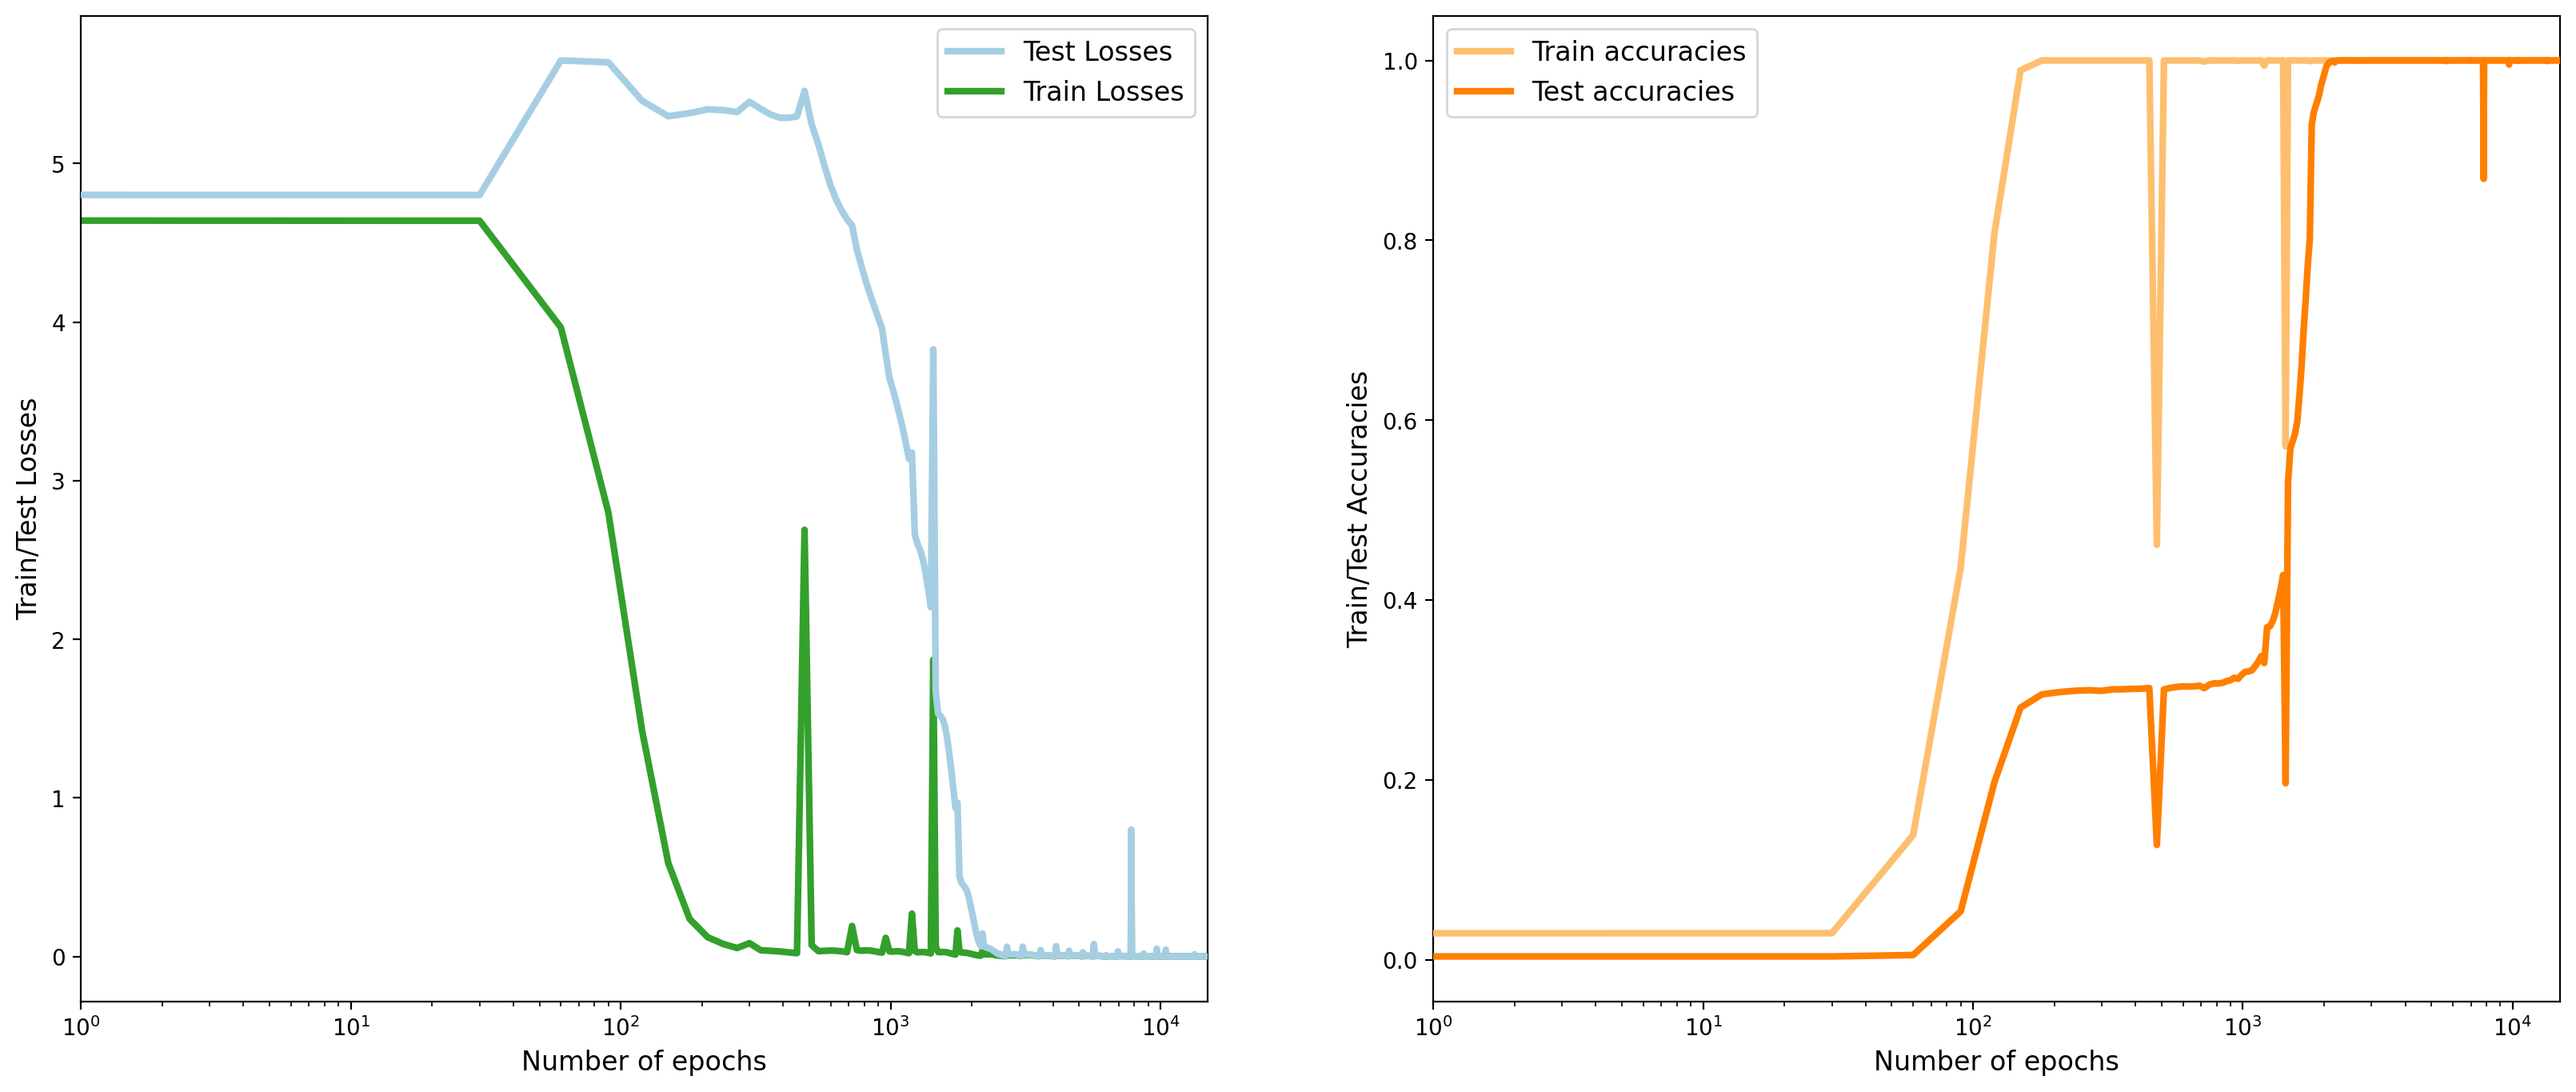

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=200,figsize=[20,8])
ax[0].plot(log_steps, test_losses, color=Z[0], linewidth=3, label='Test Losses',zorder=4)
ax[0].plot(log_steps, train_losses, color=Z[3],linewidth=3,label='Train Losses',zorder=1)
ax[0].legend()
ax[0].set_ylabel('Train/Test Losses',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 1.5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')

ax[1].plot(log_steps, train_accuracies, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[1].plot(log_steps, test_accuracies, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Accuracies',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 1.5*10**4)
ax[1].set_xscale('log')
ax[1].legend(fontsize='large')

## LoRA Fine-tuning

### Parameter of the model

In [ ]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

### Hyperparameters of the training r=1

In [ ]:
config = peft.LoraConfig(
    r=1,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix"]
)
lr=10e-3
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 768 || all params: 230,144 || trainable%: 0.3337041156840934


In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wk_ft1= []
Attn_wq_ft1= []
Attn_wv_ft1=[]
Attn_wo_ft1=[]
log_steps = []
train_losses__ft1 = []
test_losses__ft1= []
train_accuracies__ft1 = []
test_accuracies__ft1 = []
test_accuracies__ft_plus1 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_ft1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_ft1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_ft1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus1.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft1.append(train_loss.item())
            test_losses__ft1.append(test_loss__1.item())
            train_accuracies__ft1.append(full_accuracy(model, train, device))
            test_accuracies__ft1.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft1[-1], test_losses__ft1[-1], train_accuracies__ft1[-1], test_accuracies__ft1[-1], norms[-1],test_accuracies__ft_plus1[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 20.879808 |  Test loss: 21.132483 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.555396 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 7.249177 |  Test loss: 7.414340 | train_acc: 0.02 | test_acc: 0.01 | l2: 51.857590 | Test_mod_add: 0.038922  
epoch: 60  | Train loss: 6.182014 |  Test loss: 6.370933 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.937999 | Test_mod_add: 0.029368  
epoch: 90  | Train loss: 5.967221 |  Test loss: 6.169688 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.970452 | Test_mod_add: 0.024512  
epoch: 120  | Train loss: 5.899318 |  Test loss: 6.075268 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.998089 | Test_mod_add: 0.022241  
epoch: 150  | Train loss: 5.843169 |  Test loss: 6.018242 | train_acc: 0.01 | test_acc: 0.01 | l2: 52.029909 | Test_mod_add: 0.020283  
epoch: 180  | Train loss: 5.809333 |  Test loss: 5.969881 | train_acc: 0.01 | test_acc: 0.01 | l2: 52.061166 | Test_mod_add: 0.016838  
epoch: 210  | Train loss: 5.789296 |  Test loss: 5.

In [ ]:
wk_1= [Attn_wk_ft1[i] for i in range(len(Attn_wk_ft1))]
wq_1= [Attn_wq_ft1[i] for i in range(len(Attn_wq_ft1))]
wv_1= [(Attn_wv_ft1[i]) for i in range(len(Attn_wv_ft1))]

spv=[np.linalg.eigvals(x) for x in wv_1 ]
spq=[np.linalg.eigvals(x) for x in wq_1 ]
spk=[np.linalg.eigvals(x) for x in wk_1]

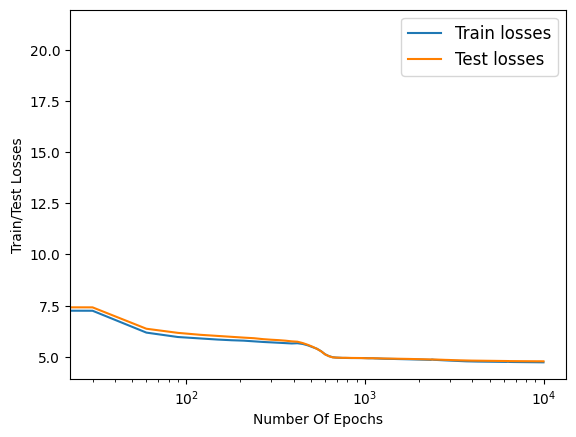

In [ ]:
plt.figure
plt.plot(log_steps,train_losses__ft1, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft1, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

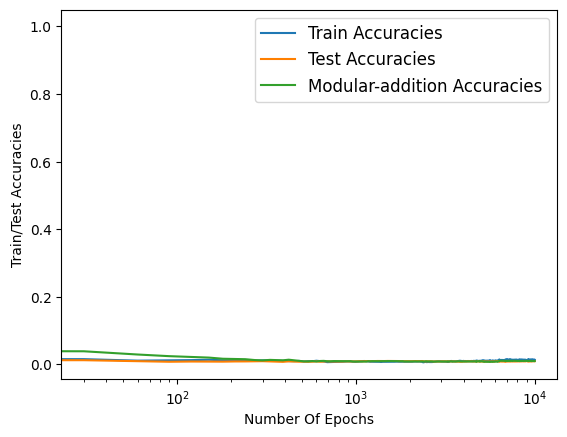

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies__ft1 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft1, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus1, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

#### Vizualizing dynamics

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=4,dpi=200,figsize=[35,8])
ax[0].plot(Q, train_accuracies__ft, color='red', label='Train Accuracy ',zorder=3)
ax[0].plot(Q, test_accuracies__ft, color='green', label='Test Accuracy',zorder=3)
ax[0].plot(Q,test_accuracies__ft_plus, color=U[0], label='Modular addition Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Numbers of Epochs")
ax[0].set_xlim(1, 1.50*10**4)
ax[0].set_ylabel("Accuracies")
#plt.xscale('log')
ax[0].legend(loc=(0.015, 0.72))
ax[0].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=1", fontsize=11)

ax[1].plot(Q, train_accuracies__ft4, color='red', label='Train Accuracy ',zorder=3)
ax[1].plot(Q, test_accuracies__ft4, color='green', label='Test Accuracy',zorder=3)
ax[1].plot(Q,test_accuracies__ft_plus4, color=U[0], label='Modular addition Accuracy' )
ax[1].legend()
ax[1].set_xlabel("Numbers of Epochs")
ax[1].set_xlim(1, 1.50*10**4)
ax[1].set_ylabel("Accuracies")
ax[1].legend(loc=(0.015, 0.72))
ax[1].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=4", fontsize=11)

ax[2].plot(log_steps_2, train_accuracies__ft8, color='red', label='Train Accuracy ',zorder=3)
ax[2].plot(log_steps_2, test_accuracies__ft8, color='green', label='Test Accuracy',zorder=3)
ax[2].plot(log_steps_2,test_accuracies__ft_plus8, color=U[0], label='Modular addition Accuracy' )
ax[2].legend()
ax[2].set_xlabel("Numbers of Epochs")
ax[2].set_xlim(1, 2.0*10**4)
ax[2].set_ylabel("Accuracies")
ax[2].legend(loc=(0.015, 0.72))
ax[2].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=8", fontsize=11)

ax[3].plot(Q, train_accuracies__ft2, color='red', label='Train Accuracy ',zorder=3)
ax[3].plot(Q, test_accuracies__ft2, color='green', label='Test Accuracy',zorder=3)
ax[3].plot(Q,test_accuracies__ft_plus2, color=U[0], label='Modular addition Accuracy' )
ax[3].legend()
ax[3].set_xlabel("Numbers of Epochs")
ax[3].set_xlim(1, 1.50*10**4)
ax[3].set_ylabel("Accuracies")
#plt.xscale('log')
ax[3].legend(loc=(0.015, 0.72))
ax[3].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=16", fontsize=11)

### Hyperparameters of the training r=16

In [ ]:
config = peft.LoraConfig(
    r=16,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix"]
)
lr=10e-3
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 12,288 || all params: 241,664 || trainable%: 5.084745762711864


In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wk_ft4= []
Attn_wq_ft4= []
Attn_wv_ft4=[]
Attn_wo_ft4=[]
Attn1_wk_ft4= []
Attn1_wq_ft4= []
Attn1_wv_ft4=[]
Attn1_wo_ft4=[]
MLP_wout_ft4= []
MLP_win_ft4= []
log_steps = []
train_losses__ft4 = []
test_losses__ft4= []
train_accuracies__ft4 = []
test_accuracies__ft4 = []
test_accuracies__ft_plus4 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_ft4.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_ft4.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_ft4.append(model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus4.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft4.append(train_loss.item())
            test_losses__ft4.append(test_loss__1.item())
            train_accuracies__ft4.append(full_accuracy(model, train, device))
            test_accuracies__ft4.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft4[-1], test_losses__ft4[-1], train_accuracies__ft4[-1], test_accuracies__ft4[-1], norms[-1],test_accuracies__ft_plus4[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 21.029572 |  Test loss: 21.068323 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.702114 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 6.794702 |  Test loss: 6.847386 | train_acc: 0.01 | test_acc: 0.01 | l2: 55.452076 | Test_mod_add: 0.012609  
epoch: 60  | Train loss: 5.071287 |  Test loss: 5.135878 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.518540 | Test_mod_add: 0.010024  
epoch: 90  | Train loss: 4.865515 |  Test loss: 4.937146 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.605463 | Test_mod_add: 0.008458  
epoch: 120  | Train loss: 4.794907 |  Test loss: 4.882924 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.633071 | Test_mod_add: 0.008066  
epoch: 150  | Train loss: 4.740559 |  Test loss: 4.851712 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.657189 | Test_mod_add: 0.008693  
epoch: 180  | Train loss: 4.689752 |  Test loss: 4.822838 | train_acc: 0.03 | test_acc: 0.01 | l2: 56.573330 | Test_mod_add: 0.010024  
epoch: 210  | Train loss: 4.619252 |  Test loss: 4.

In [ ]:
wk= [Attn_wk_ft4[i] for i in range(len(Attn_wk_ft4))]
wq= [Attn_wq_ft4[i] for i in range(len(Attn_wq_ft4))]
wv= [(Attn_wv_ft4[i]-Attn_wv[-1]) for i in range(len(Attn_wv_ft4))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

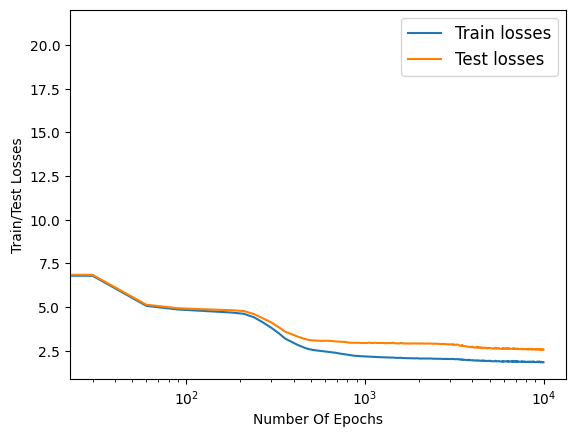

In [ ]:
plt.figure
plt.plot(log_steps,train_losses__ft4, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft4, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

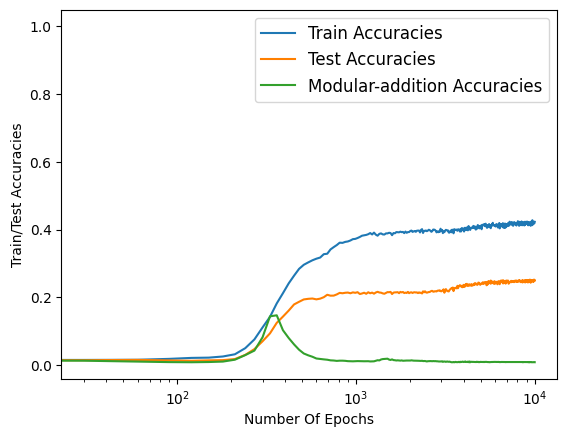

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies__ft4 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft4, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus4, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

#### Scalar products etc

#### Vizualizing dynamics

NameError: name 'Q' is not defined

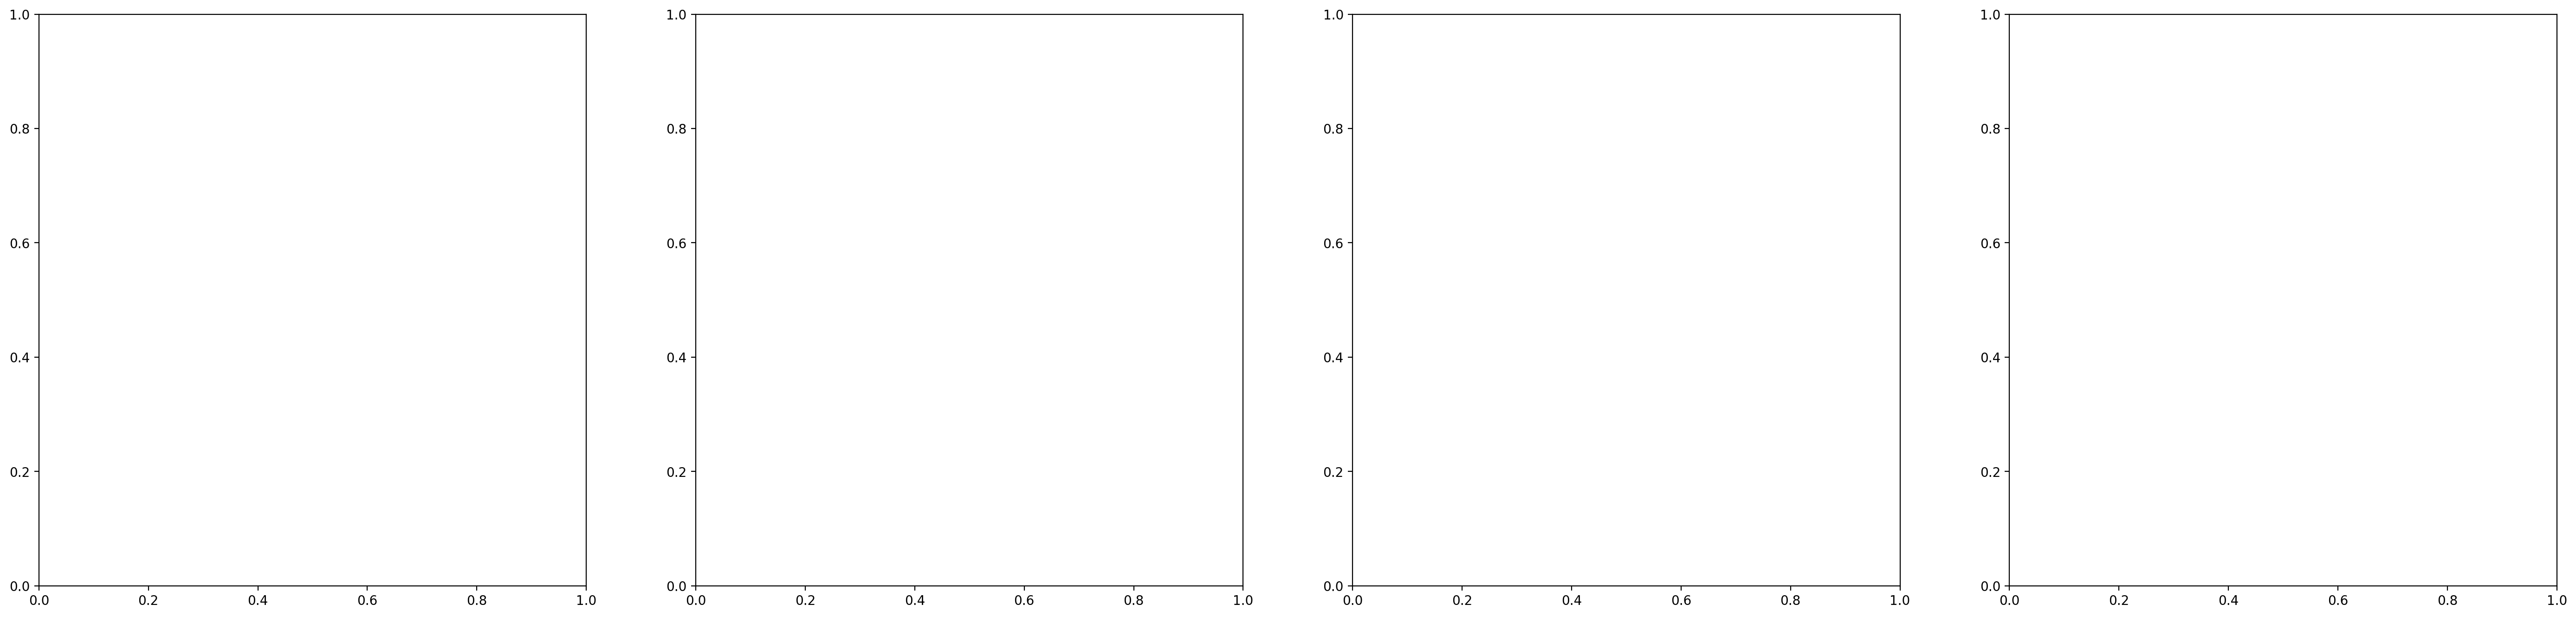

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=4,dpi=200,figsize=[35,8])
ax[0].plot(Q, train_accuracies__ft, color='red', label='Train Accuracy ',zorder=3)
ax[0].plot(Q, test_accuracies__ft, color='green', label='Test Accuracy',zorder=3)
ax[0].plot(Q,test_accuracies__ft_plus, color=U[0], label='Modular addition Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Numbers of Epochs")
ax[0].set_xlim(1, 1.50*10**4)
ax[0].set_ylabel("Accuracies")
#plt.xscale('log')
ax[0].legend(loc=(0.015, 0.72))
ax[0].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=1", fontsize=11)

ax[1].plot(Q, train_accuracies__ft4, color='red', label='Train Accuracy ',zorder=3)
ax[1].plot(Q, test_accuracies__ft4, color='green', label='Test Accuracy',zorder=3)
ax[1].plot(Q,test_accuracies__ft_plus4, color=U[0], label='Modular addition Accuracy' )
ax[1].legend()
ax[1].set_xlabel("Numbers of Epochs")
ax[1].set_xlim(1, 1.50*10**4)
ax[1].set_ylabel("Accuracies")
ax[1].legend(loc=(0.015, 0.72))
ax[1].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=4", fontsize=11)

ax[2].plot(log_steps_2, train_accuracies__ft8, color='red', label='Train Accuracy ',zorder=3)
ax[2].plot(log_steps_2, test_accuracies__ft8, color='green', label='Test Accuracy',zorder=3)
ax[2].plot(log_steps_2,test_accuracies__ft_plus8, color=U[0], label='Modular addition Accuracy' )
ax[2].legend()
ax[2].set_xlabel("Numbers of Epochs")
ax[2].set_xlim(1, 2.0*10**4)
ax[2].set_ylabel("Accuracies")
ax[2].legend(loc=(0.015, 0.72))
ax[2].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=8", fontsize=11)

ax[3].plot(Q, train_accuracies__ft2, color='red', label='Train Accuracy ',zorder=3)
ax[3].plot(Q, test_accuracies__ft2, color='green', label='Test Accuracy',zorder=3)
ax[3].plot(Q,test_accuracies__ft_plus2, color=U[0], label='Modular addition Accuracy' )
ax[3].legend()
ax[3].set_xlabel("Numbers of Epochs")
ax[3].set_xlim(1, 1.50*10**4)
ax[3].set_ylabel("Accuracies")
#plt.xscale('log')
ax[3].legend(loc=(0.015, 0.72))
ax[3].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=16", fontsize=11)

### Hyperparameters of the training r=32

In [ ]:
config = peft.LoraConfig(
    r=32,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix"]
)
lr=10e-3
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 24,576 || all params: 253,952 || trainable%: 9.67741935483871


In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wk_ft32= []
Attn_wq_ft32= []
Attn_wv_ft32=[]
Attn_wo_ft32=[]
log_steps = []
train_losses__ft32 = []
test_losses__ft32= []
train_accuracies__ft32 = []
test_accuracies__ft32 = []
test_accuracies__ft_plus32 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus32.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft32.append(train_loss.item())
            test_losses__ft32.append(test_loss__1.item())
            train_accuracies__ft32.append(full_accuracy(model, train, device))
            test_accuracies__ft32.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft32[-1], test_losses__ft32[-1], train_accuracies__ft32[-1], test_accuracies__ft32[-1], norms[-1],test_accuracies__ft_plus32[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 21.081238 |  Test loss: 21.046181 | train_acc: 0.01 | test_acc: 0.01 | l2: 51.855260 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 6.734549 |  Test loss: 6.881530 | train_acc: 0.01 | test_acc: 0.01 | l2: 58.740043 | Test_mod_add: 0.008693  
epoch: 60  | Train loss: 5.146880 |  Test loss: 5.216311 | train_acc: 0.01 | test_acc: 0.01 | l2: 60.648380 | Test_mod_add: 0.008928  
epoch: 90  | Train loss: 4.936086 |  Test loss: 5.003016 | train_acc: 0.02 | test_acc: 0.01 | l2: 60.856635 | Test_mod_add: 0.008301  
epoch: 120  | Train loss: 4.854414 |  Test loss: 4.938137 | train_acc: 0.02 | test_acc: 0.01 | l2: 61.068669 | Test_mod_add: 0.008145  
epoch: 150  | Train loss: 4.777218 |  Test loss: 4.892402 | train_acc: 0.02 | test_acc: 0.02 | l2: 60.968107 | Test_mod_add: 0.008693  
epoch: 180  | Train loss: 4.665427 |  Test loss: 4.830387 | train_acc: 0.03 | test_acc: 0.02 | l2: 60.347998 | Test_mod_add: 0.010494  
epoch: 210  | Train loss: 4.356358 |  Test loss: 4.

In [ ]:
wk_32= [Attn_wk_ft32[i] for i in range(len(Attn_wk_ft32))]
wq_32= [Attn_wq_ft32[i] for i in range(len(Attn_wq_ft32))]
wv_32= [(Attn_wv_ft32[i]) for i in range(len(Attn_wv_ft32))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

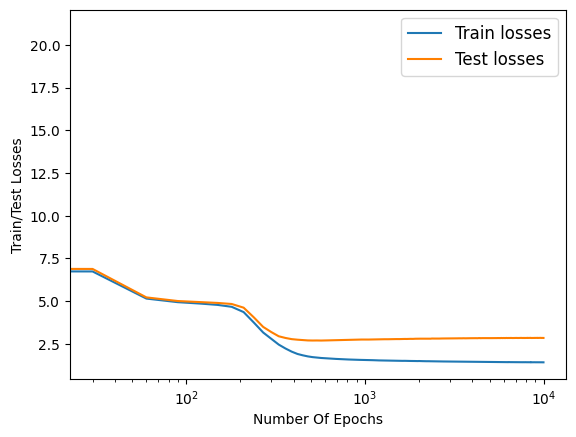

In [ ]:
plt.figure
plt.plot(log_steps,train_losses__ft32, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft32, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

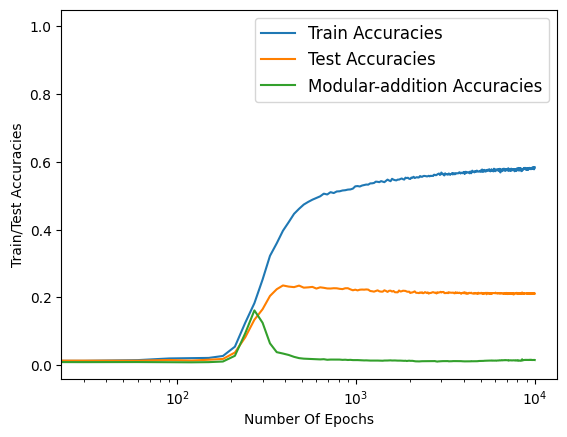

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies__ft32 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft32, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus32, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=4,dpi=200,figsize=[35,8])
ax[0].plot(Q, train_accuracies__ft, color='red', label='Train Accuracy ',zorder=3)
ax[0].plot(Q, test_accuracies__ft, color='green', label='Test Accuracy',zorder=3)
ax[0].plot(Q,test_accuracies__ft_plus, color=U[0], label='Modular addition Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Numbers of Epochs")
ax[0].set_xlim(1, 1.50*10**4)
ax[0].set_ylabel("Accuracies")
#plt.xscale('log')
ax[0].legend(loc=(0.015, 0.72))
ax[0].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=1", fontsize=11)

ax[1].plot(Q, train_accuracies__ft4, color='red', label='Train Accuracy ',zorder=3)
ax[1].plot(Q, test_accuracies__ft4, color='green', label='Test Accuracy',zorder=3)
ax[1].plot(Q,test_accuracies__ft_plus4, color=U[0], label='Modular addition Accuracy' )
ax[1].legend()
ax[1].set_xlabel("Numbers of Epochs")
ax[1].set_xlim(1, 1.50*10**4)
ax[1].set_ylabel("Accuracies")
ax[1].legend(loc=(0.015, 0.72))
ax[1].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=4", fontsize=11)

ax[2].plot(log_steps_2, train_accuracies__ft8, color='red', label='Train Accuracy ',zorder=3)
ax[2].plot(log_steps_2, test_accuracies__ft8, color='green', label='Test Accuracy',zorder=3)
ax[2].plot(log_steps_2,test_accuracies__ft_plus8, color=U[0], label='Modular addition Accuracy' )
ax[2].legend()
ax[2].set_xlabel("Numbers of Epochs")
ax[2].set_xlim(1, 2.0*10**4)
ax[2].set_ylabel("Accuracies")
ax[2].legend(loc=(0.015, 0.72))
ax[2].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=8", fontsize=11)

ax[3].plot(Q, train_accuracies__ft2, color='red', label='Train Accuracy ',zorder=3)
ax[3].plot(Q, test_accuracies__ft2, color='green', label='Test Accuracy',zorder=3)
ax[3].plot(Q,test_accuracies__ft_plus2, color=U[0], label='Modular addition Accuracy' )
ax[3].legend()
ax[3].set_xlabel("Numbers of Epochs")
ax[3].set_xlim(1, 1.50*10**4)
ax[3].set_ylabel("Accuracies")
#plt.xscale('log')
ax[3].legend(loc=(0.015, 0.72))
ax[3].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=16", fontsize=11)

# Transformer with 2 layers (Training and Fine-Tuning)  


## Model declaration

### Data

In [ ]:
seed = 72
p = 113
fraction = 0.3
equals_token= p

In [ ]:
device='cuda'

In [ ]:
equals_token = p
fraction=0.3
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
plus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+1)
prompts = torch.stack([x, plus, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])


### Model

In [ ]:
model_2 = Transformer(num_layers=2,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                ).to(device)

## Training loop for modular addition

In [ ]:
optimizer = torch.optim.AdamW(model_2.parameters(), lr=1.0e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=300, threshold=10e-8,verbose=True)
log_steps = []
train_losses_2 = []
test_losses_2 = []
train_accuracies_2 = []
test_accuracies_2 = []
norms_2 = []
for epoch in tqdm(range(15000)):
  train_loss = full_loss(model_2, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
    with torch.no_grad():
          log_steps.append(epoch)
          test_loss = full_loss(model_2, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_2.append(train_loss.item())
          test_losses_2.append(test_loss.item())
          train_accuracies_2.append(full_accuracy(model_2, train, device))
          test_accuracies_2.append(full_accuracy(model_2, test, device))
          norms_2.append(np.sqrt(sum(param.pow(2).sum().item() for param in model_2.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f |  l2: %.6f"%(epoch, train_losses_2[-1], test_losses_2[-1], train_accuracies_2[-1], test_accuracies_2[-1], norms_2[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()



  0%|          | 0/15000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.381475 |  Test loss: 5.336109 | train_acc: 0.01 | test_acc: 0.01 |  l2: 65.523680
epoch: 30  | Train loss: 4.676229 |  Test loss: 4.771161 | train_acc: 0.02 | test_acc: 0.00 |  l2: 64.607440
epoch: 60  | Train loss: 3.877068 |  Test loss: 5.611773 | train_acc: 0.13 | test_acc: 0.00 |  l2: 64.450255
epoch: 90  | Train loss: 2.648655 |  Test loss: 5.836215 | train_acc: 0.48 | test_acc: 0.01 |  l2: 64.607634
epoch: 120  | Train loss: 1.323181 |  Test loss: 5.924975 | train_acc: 0.87 | test_acc: 0.03 |  l2: 64.998465
epoch: 150  | Train loss: 0.483175 |  Test loss: 5.987168 | train_acc: 1.00 | test_acc: 0.06 |  l2: 65.180598
epoch: 180  | Train loss: 0.187655 |  Test loss: 6.056933 | train_acc: 1.00 | test_acc: 0.09 |  l2: 65.078311
epoch: 210  | Train loss: 0.097011 |  Test loss: 6.067597 | train_acc: 1.00 | test_acc: 0.10 |  l2: 64.691457
epoch: 240  | Train loss: 0.201088 |  Test loss: 6.201127 | train_acc: 1.00 | test_acc: 0.10 |  l2: 64.670973
epoch: 270  | T

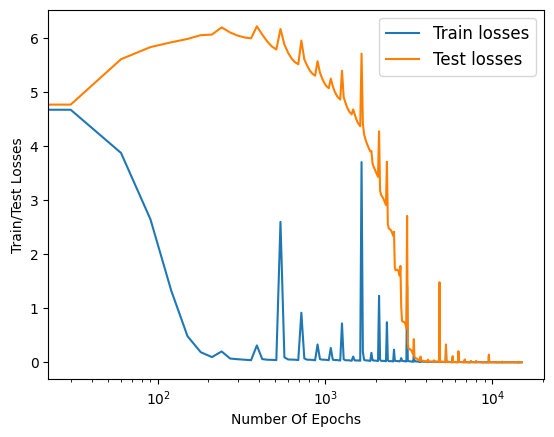

In [ ]:
plt.figure
plt.plot(log_steps,train_losses_2, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses_2, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

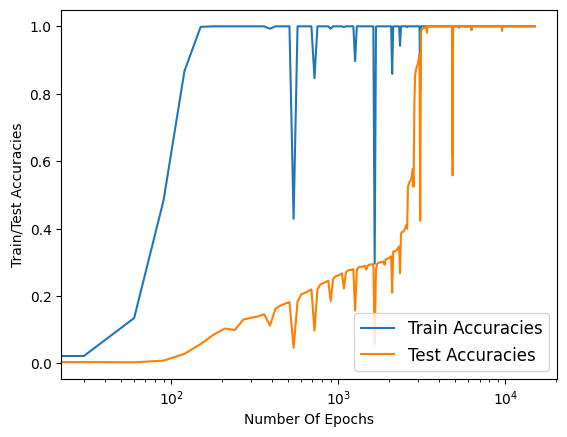

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies_2 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies_2, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=200,figsize=[20,8])
ax[0].plot(log_steps, test_losses_2, color=Z[0], linewidth=3, label='Test Losses',zorder=4)
ax[0].plot(log_steps, train_losses_2, color=Z[3],linewidth=3,label='Train Losses',zorder=1)
ax[0].legend()
ax[0].set_ylabel('Train/Test Losses',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 1.5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')

ax[1].plot(log_steps, train_accuracies_2, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[1].plot(log_steps, test_accuracies_2, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Accuracies',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 1.5*10**4)
ax[1].set_xscale('log')
ax[1].legend(fontsize='large')

## LoRA Fine-tuning

### Parameter of the model

In [ ]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

Hyperparameters of the training

In [ ]:
config = peft.LoraConfig(
    r=1,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix","blocks.1.attn.key_matrix", "blocks.1.attn.query_matrix","blocks.1.attn.value_matrix"]
)
lr=10e-3
model = model_2.to(device)
model_copy = copy.deepcopy(model_2)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 1,536 || all params: 429,824 || trainable%: 0.357355568790947


In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wk_ft_1= []
Attn_wq_ft_1= []
Attn_wv_ft_1=[]
Attn1_wk_ft_2= []
Attn1_wq_ft_2= []
Attn1_wv_ft_2=[]
log_steps = []
train_losses__ft_1 = []
test_losses__ft_1= []
train_accuracies__ft_2 = []
test_accuracies__ft_2 = []
test_accuracies__ft_plus_2 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_ft_1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_ft_1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_ft_1.append(model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus_2.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss.item(),train_loss.item()
            train_losses__ft_1.append(train_loss.item())
            test_losses__ft_1.append(test_loss.item())
            train_accuracies__ft_2.append(full_accuracy(model, train, device))
            test_accuracies__ft_2.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft_1[-1], test_losses__ft_1[-1], train_accuracies__ft_2[-1], test_accuracies__ft_2[-1], norms[-1],test_accuracies__ft_plus_2[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 17.336691 |  Test loss: 0.000078 | train_acc: 0.01 | test_acc: 0.01 | l2: 55.888564 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 6.810635 |  Test loss: 0.000078 | train_acc: 0.01 | test_acc: 0.01 | l2: 56.403319 | Test_mod_add: 0.031091  
epoch: 60  | Train loss: 5.262458 |  Test loss: 0.000078 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.573026 | Test_mod_add: 0.027723  
epoch: 90  | Train loss: 5.067880 |  Test loss: 0.000078 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.679717 | Test_mod_add: 0.035555  
epoch: 120  | Train loss: 4.985724 |  Test loss: 0.000078 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.819407 | Test_mod_add: 0.036965  
epoch: 150  | Train loss: 4.937983 |  Test loss: 0.000078 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.891507 | Test_mod_add: 0.042133  
epoch: 180  | Train loss: 4.893435 |  Test loss: 0.000078 | train_acc: 0.02 | test_acc: 0.01 | l2: 56.982042 | Test_mod_add: 0.048868  
epoch: 210  | Train loss: 4.861590 |  Test loss: 0.0

In [ ]:
wk= [Attn_wk_ft4[i] for i in range(len(Attn_wk_ft4))]
wq= [Attn_wq_ft4[i] for i in range(len(Attn_wq_ft4))]
wv= [(Attn_wv_ft4[i]-Attn_wv[-1]) for i in range(len(Attn_wv_ft4))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

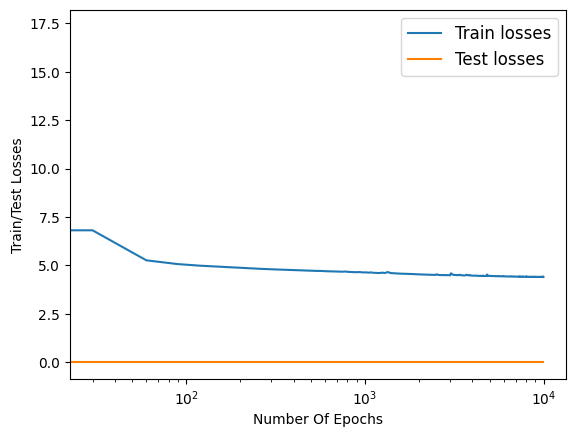

In [ ]:
plt.figure
plt.plot(log_steps,train_losses__ft_1 , color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft_1 , color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

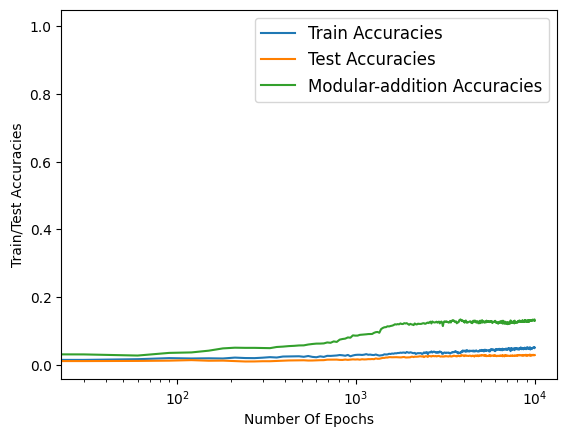

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies__ft_2 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft_2, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus_2, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

### Parameter of the model

Hyperparameters of the training

In [ ]:
config = peft.LoraConfig(
    r=16,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix","blocks.1.attn.key_matrix", "blocks.1.attn.query_matrix","blocks.1.attn.value_matrix"]
)
lr=10e-3
model = model_2.to(device)
model_copy = copy.deepcopy(model_2)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 24,576 || all params: 452,864 || trainable%: 5.426794799321651


In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
log_steps = []
train_losses__ft_2_16 = []
test_losses__ft_2_16= []
train_accuracies__ft_2_16 = []
test_accuracies__ft_2_16 = []
test_accuracies__ft_plus_2_16 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus_2_16.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss.item(),train_loss.item()
            train_losses__ft_2_16.append(train_loss.item())
            test_losses__ft_2_16.append(test_loss.item())
            train_accuracies__ft_2_16.append(full_accuracy(model, train, device))
            test_accuracies__ft_2_16.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft_2_16[-1], test_losses__ft_2_16[-1], train_accuracies__ft_2_16[-1], test_accuracies__ft_2_16[-1], norms[-1],test_accuracies__ft_plus_2_16[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 17.409918 |  Test loss: 0.000078 | train_acc: 0.01 | test_acc: 0.01 | l2: 56.157690 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 5.248648 |  Test loss: 0.000078 | train_acc: 0.04 | test_acc: 0.02 | l2: 63.869603 | Test_mod_add: 0.023651  
epoch: 60  | Train loss: 4.226209 |  Test loss: 0.000078 | train_acc: 0.08 | test_acc: 0.05 | l2: 63.715991 | Test_mod_add: 0.058266  
epoch: 90  | Train loss: 3.474831 |  Test loss: 0.000078 | train_acc: 0.17 | test_acc: 0.11 | l2: 63.756453 | Test_mod_add: 0.091941  
epoch: 120  | Train loss: 2.803460 |  Test loss: 0.000078 | train_acc: 0.25 | test_acc: 0.16 | l2: 64.864152 | Test_mod_add: 0.099851  
epoch: 150  | Train loss: 2.493845 |  Test loss: 0.000078 | train_acc: 0.30 | test_acc: 0.18 | l2: 67.529490 | Test_mod_add: 0.080821  
epoch: 180  | Train loss: 2.314300 |  Test loss: 0.000078 | train_acc: 0.33 | test_acc: 0.19 | l2: 70.121242 | Test_mod_add: 0.076122  
epoch: 210  | Train loss: 2.160626 |  Test loss: 0.0

In [ ]:
wk= [Attn_wk_ft4[i] for i in range(len(Attn_wk_ft4))]
wq= [Attn_wq_ft4[i] for i in range(len(Attn_wq_ft4))]
wv= [(Attn_wv_ft4[i]-Attn_wv[-1]) for i in range(len(Attn_wv_ft4))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

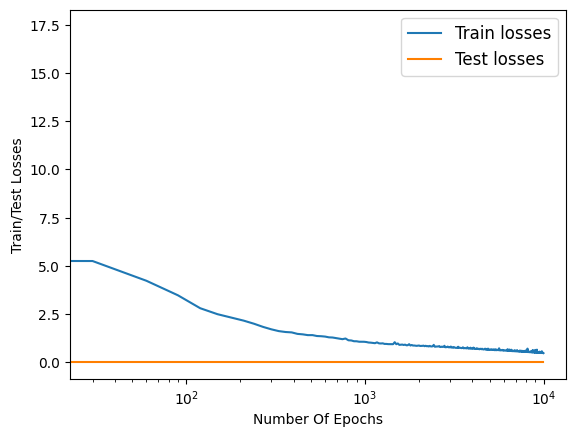

In [ ]:
plt.figure
plt.plot(log_steps,train_losses__ft_2_16, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft_2_16, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

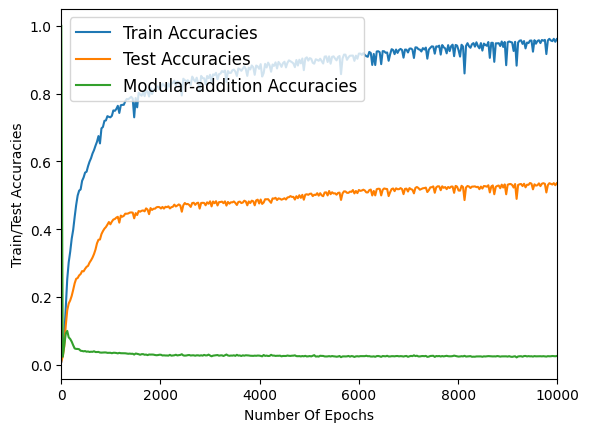

In [ ]:
plt.figure
plt.plot(log_steps,train_accuracies__ft_2_16, color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft_2_16, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus_2_16, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
#plt.xscale('log')
plt.xlim(0,10e3)
plt.show()

### Scalar products etc

In [ ]:
scalar_product_WK=[scalar_product(Attn_wk_ft[i],Attn_wk[-1]) for i in range(545)]
scalar_product_WQ=[scalar_product(Attn_wq_ft[i],Attn_wq[-1]) for i in range(545)]

In [ ]:
ax = plt.figure(figsize=[10,5],dpi=500)
plt.plot(range(545), scalar_product_WK, color=L[2], label='Normalized Scalar Product between W_K attention matrix ',zorder=3)
plt.plot(range(545), scalar_product_WQ, color=U[6], label='Normalized Scalar Product between W_Q attention matrix',zorder=2)
#plt.plot(log_steps, rk_wk_ft,color=L[0], linewidth=2, label='Normalized W_K rank',zorder=0)
#plt.plot(log_steps, rk_wq_ft, color=L[1], linewidth=2, label='Normalized W_Q rank',zorder=0)
plt.legend()
plt.xlabel("Numbers of Epochs")
plt.xlim(0, 545)
plt.ylabel("Angle between the model pretrained W_K and the Finetuning W_K")
plt.legend()
plt.title("Dynamics of Scalar Product During FineTuning", fontsize=11)
plt.tight_layout()
plt.savefig('/content/scalar_product')

### Vizualizing dynamics

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=4,dpi=200,figsize=[35,8])
ax[0].plot(Q, train_accuracies__ft, color='red', label='Train Accuracy ',zorder=3)
ax[0].plot(Q, test_accuracies__ft, color='green', label='Test Accuracy',zorder=3)
ax[0].plot(Q,test_accuracies__ft_plus, color=U[0], label='Modular addition Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Numbers of Epochs")
ax[0].set_xlim(1, 1.50*10**4)
ax[0].set_ylabel("Accuracies")
#plt.xscale('log')
ax[0].legend(loc=(0.015, 0.72))
ax[0].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=1", fontsize=11)

ax[1].plot(Q, train_accuracies__ft4, color='red', label='Train Accuracy ',zorder=3)
ax[1].plot(Q, test_accuracies__ft4, color='green', label='Test Accuracy',zorder=3)
ax[1].plot(Q,test_accuracies__ft_plus4, color=U[0], label='Modular addition Accuracy' )
ax[1].legend()
ax[1].set_xlabel("Numbers of Epochs")
ax[1].set_xlim(1, 1.50*10**4)
ax[1].set_ylabel("Accuracies")
ax[1].legend(loc=(0.015, 0.72))
ax[1].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=4", fontsize=11)

ax[2].plot(log_steps_2, train_accuracies__ft8, color='red', label='Train Accuracy ',zorder=3)
ax[2].plot(log_steps_2, test_accuracies__ft8, color='green', label='Test Accuracy',zorder=3)
ax[2].plot(log_steps_2,test_accuracies__ft_plus8, color=U[0], label='Modular addition Accuracy' )
ax[2].legend()
ax[2].set_xlabel("Numbers of Epochs")
ax[2].set_xlim(1, 2.0*10**4)
ax[2].set_ylabel("Accuracies")
ax[2].legend(loc=(0.015, 0.72))
ax[2].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=8", fontsize=11)

ax[3].plot(Q, train_accuracies__ft2, color='red', label='Train Accuracy ',zorder=3)
ax[3].plot(Q, test_accuracies__ft2, color='green', label='Test Accuracy',zorder=3)
ax[3].plot(Q,test_accuracies__ft_plus2, color=U[0], label='Modular addition Accuracy' )
ax[3].legend()
ax[3].set_xlabel("Numbers of Epochs")
ax[3].set_xlim(1, 1.50*10**4)
ax[3].set_ylabel("Accuracies")
#plt.xscale('log')
ax[3].legend(loc=(0.015, 0.72))
ax[3].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=16", fontsize=11)

# Transformer with 4 layers (Training and Fine-Tuning)  


## Model declaration

### Imports

In [131]:
equals_token = p
fraction=0.3
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
plus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+1)
prompts = torch.stack([x, plus, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])


### Model

In [132]:
model_4 = Transformer(num_layers=4,
                    d_vocab=equals_token+3,
                    d_model=128,
                    d_mlp=512,
                    d_head=128,
                    num_heads=1,
                    n_ctx=4, # context length
                    act_type='ReLU',
                    use_cache=False,
                    use_ln=True, # use LayerNorm,
                ).to(device)

## Training loop for modular addition

In [133]:
optimizer = torch.optim.AdamW(model_4.parameters(), lr=1.0e-3, weight_decay=1.0, betas=(0.9, 0.98))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.95,patience=300, threshold=10e-8,verbose=True)
log_steps = []
train_losses_4 = []
test_losses_4 = []
train_accuracies_4 = []
test_accuracies_4 = []
norms = []
for epoch in tqdm(range(15000)):
  train_loss = full_loss(model_4, train, device)
  scheduler.step(train_loss)
  if epoch % 30 == 0:
    with torch.no_grad():
          log_steps.append(epoch)
          test_loss = full_loss(model_4, test, device)
          test_2,train_2=test_loss.item(),train_loss.item()
          train_losses_4.append(train_loss.item())
          test_losses_4.append(test_loss.item())
          train_accuracies_4.append(full_accuracy(model_4, train, device))
          test_accuracies_4.append(full_accuracy(model_4, test, device))
          #norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
          print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f "%(epoch, train_losses_4[-1], test_losses_4[-1], train_accuracies_4[-1], test_accuracies_4[-1]))
  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()



  0%|          | 0/15000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 5.095180 |  Test loss: 5.079140 | train_acc: 0.01 | test_acc: 0.01 
epoch: 30  | Train loss: 4.711033 |  Test loss: 4.747535 | train_acc: 0.01 | test_acc: 0.01 
epoch: 60  | Train loss: 4.137958 |  Test loss: 5.449335 | train_acc: 0.08 | test_acc: 0.00 
epoch: 90  | Train loss: 2.716659 |  Test loss: 5.933495 | train_acc: 0.45 | test_acc: 0.00 
epoch: 120  | Train loss: 1.248040 |  Test loss: 6.274598 | train_acc: 0.91 | test_acc: 0.00 
epoch: 150  | Train loss: 0.309792 |  Test loss: 6.598819 | train_acc: 1.00 | test_acc: 0.00 
epoch: 180  | Train loss: 0.102830 |  Test loss: 6.770613 | train_acc: 1.00 | test_acc: 0.00 
epoch: 210  | Train loss: 1.279480 |  Test loss: 6.705939 | train_acc: 0.76 | test_acc: 0.01 
epoch: 240  | Train loss: 0.119342 |  Test loss: 6.905328 | train_acc: 1.00 | test_acc: 0.01 
epoch: 270  | Train loss: 0.066036 |  Test loss: 6.852278 | train_acc: 1.00 | test_acc: 0.01 
epoch: 300  | Train loss: 0.056033 |  Test loss: 6.788755 | train

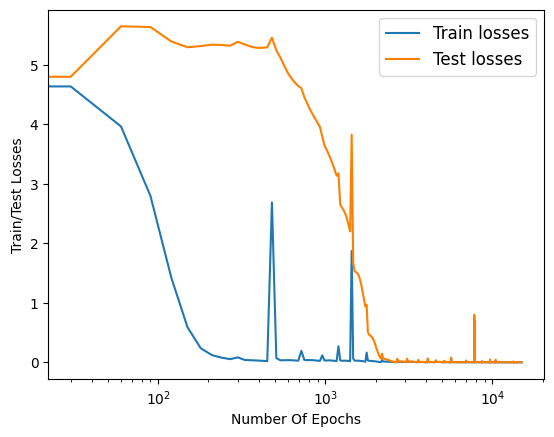

In [134]:
plt.figure
plt.plot(log_steps,train_losses, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

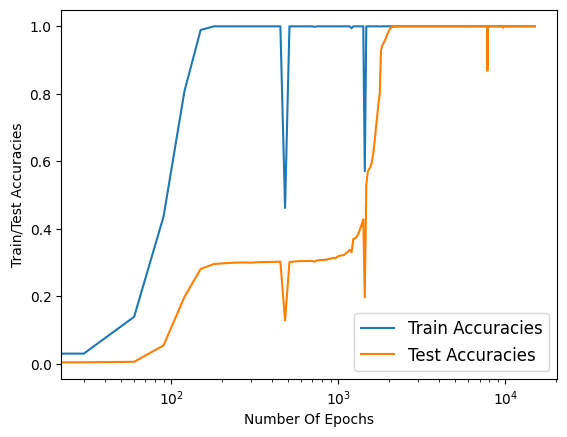

In [135]:
plt.figure
plt.plot(log_steps,train_accuracies , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies, color=Z[7],label='Test Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

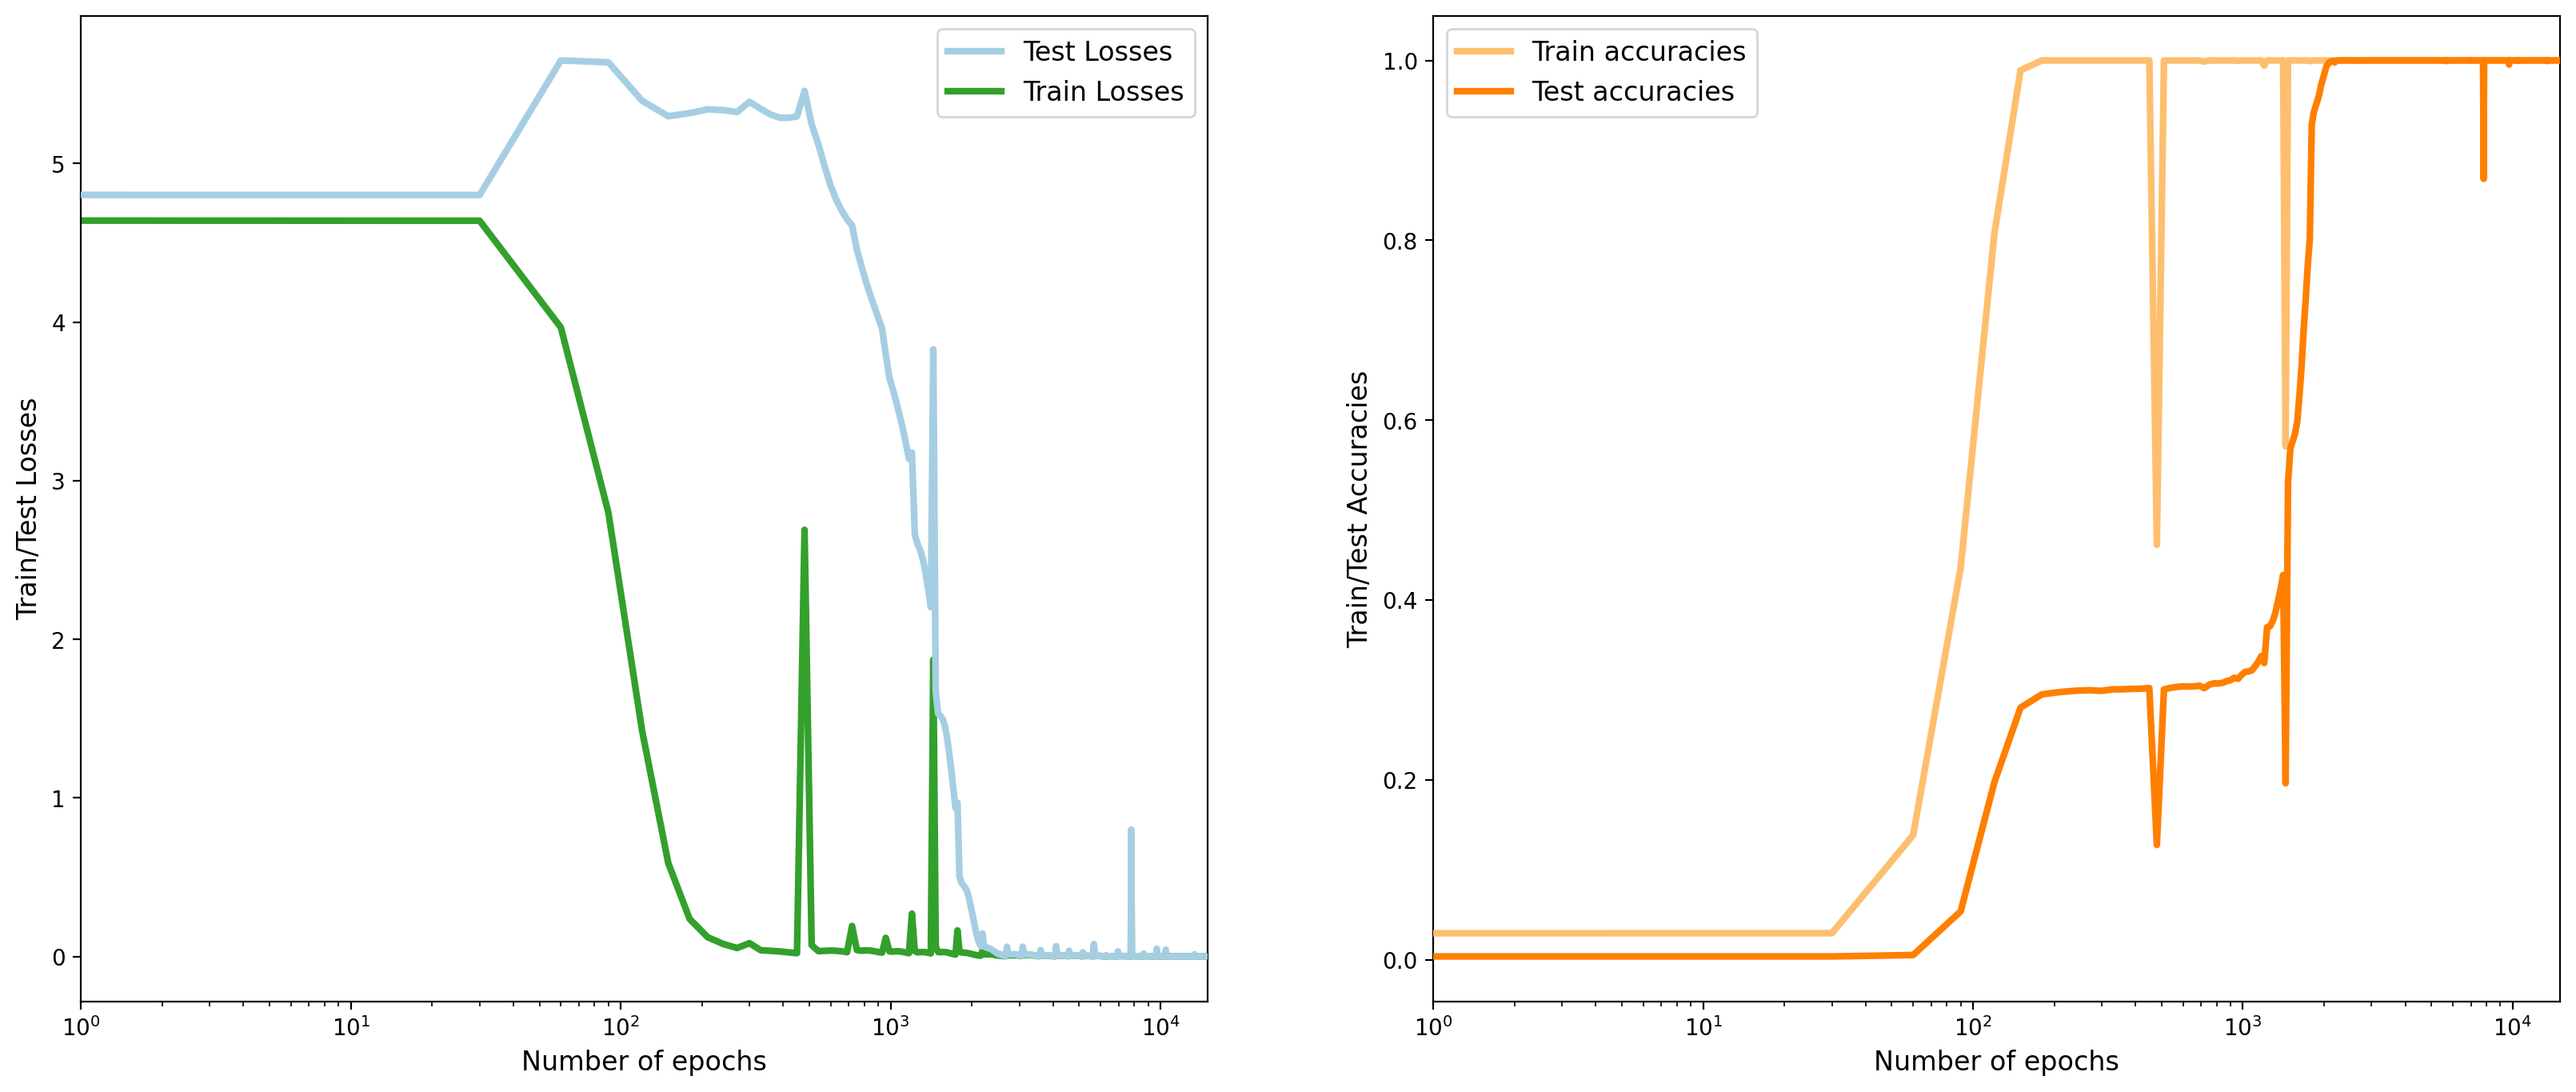

In [136]:
fig,ax=plt.subplots(nrows=1,ncols=2,dpi=200,figsize=[20,8])
ax[0].plot(log_steps, test_losses, color=Z[0], linewidth=3, label='Test Losses',zorder=4)
ax[0].plot(log_steps, train_losses, color=Z[3],linewidth=3,label='Train Losses',zorder=1)
ax[0].legend()
ax[0].set_ylabel('Train/Test Losses',fontsize='large')
ax[0].set_xlabel("Number of epochs",fontsize='large')
ax[0].set_xlim(1, 1.5*10**4)
ax[0].set_xscale('log')
ax[0].legend(fontsize='large')

ax[1].plot(log_steps, train_accuracies, color=Z[6],linewidth=3, label='Train accuracies',zorder=3)
ax[1].plot(log_steps, test_accuracies, color=Z[7],linewidth=3, label='Test accuracies',zorder=3)
ax[1].legend()
ax[1].set_ylabel('Train/Test Accuracies',fontsize='large')
ax[1].set_xlabel("Number of epochs",fontsize='large')
ax[1].set_xlim(1, 1.5*10**4)
ax[1].set_xscale('log')
ax[1].legend(fontsize='large')

## LoRA Fine-tuning

### Parameter of the model

In [137]:
d_model=128
d_mlp=512
d_head=128
num_heads=1

### Hyperparameters of the training r=1

In [138]:
config = peft.LoraConfig(
    r=1,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix","blocks.1.attn.key_matrix", "blocks.1.attn.query_matrix","blocks.1.attn.value_matrix","blocks.2.attn.key_matrix", "blocks.2.attn.query_matrix","blocks.2.attn.value_matrix"]
)
lr=10e-3
model = model_4.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

trainable params: 2,304 || all params: 828,416 || trainable%: 0.27812113720642767


In [139]:
lr=1e-3
wd=0.
epochs=15000

In [140]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [141]:
epochs=10000
train = data_train
test = data_test
log_steps = []
train_losses__ft_4_1 = []
test_losses__ft_4_1= []
train_accuracies__ft_4_1 = []
test_accuracies__ft_4_1 = []
test_accuracies__ft_plus_4_1 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus_4_1.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft_4_1.append(train_loss.item())
            test_losses__ft_4_1.append(test_loss__1.item())
            train_accuracies__ft_4_1.append(full_accuracy(model, train, device))
            test_accuracies__ft_4_1.append(full_accuracy(model, test, device))
            #norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft_4_1[-1], test_losses__ft_4_1[-1], train_accuracies__ft_4_1[-1], test_accuracies__ft_4_1[-1], test_accuracies__ft_plus_4_1[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch: 0  | Train loss: 20.012320 |  Test loss: 19.991957 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 1.000000  
epoch: 30  | Train loss: 10.096698 |  Test loss: 10.311969 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.016211  
epoch: 60  | Train loss: 8.203636 |  Test loss: 8.496116 | train_acc: 0.01 | test_acc: 0.01 | Test_mod_add: 0.019500  
epoch: 90  | Train loss: 6.881929 |  Test loss: 7.158204 | train_acc: 0.02 | test_acc: 0.02 | Test_mod_add: 0.022790  
epoch: 120  | Train loss: 6.163043 |  Test loss: 6.440964 | train_acc: 0.02 | test_acc: 0.01 | Test_mod_add: 0.024591  
epoch: 150  | Train loss: 5.467943 |  Test loss: 5.790675 | train_acc: 0.02 | test_acc: 0.01 | Test_mod_add: 0.027410  
epoch: 180  | Train loss: 5.117810 |  Test loss: 5.434178 | train_acc: 0.02 | test_acc: 0.01 | Test_mod_add: 0.025296  
epoch: 210  | Train loss: 4.996204 |  Test loss: 5.334968 | train_acc: 0.03 | test_acc: 0.01 | Test_mod_add: 0.024512  
epoch: 240  | Train loss: 4.931896 |  Tes

In [142]:
wk_1= [Attn_wk_ft1[i] for i in range(len(Attn_wk_ft1))]
wq_1= [Attn_wq_ft1[i] for i in range(len(Attn_wq_ft1))]
wv_1= [(Attn_wv_ft1[i]) for i in range(len(Attn_wv_ft1))]

spv=[np.linalg.eigvals(x) for x in wv_1 ]
spq=[np.linalg.eigvals(x) for x in wq_1 ]
spk=[np.linalg.eigvals(x) for x in wk_1]

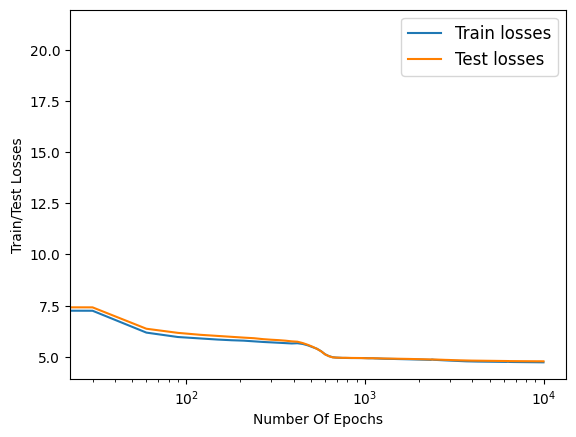

In [143]:
plt.figure
plt.plot(log_steps,train_losses__ft1, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft1, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

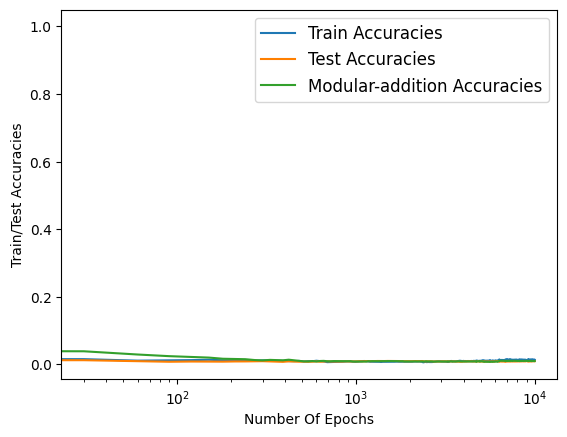

In [144]:
plt.figure
plt.plot(log_steps,train_accuracies__ft1 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft1, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus1, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

#### Vizualizing dynamics

NameError: name 'Q' is not defined

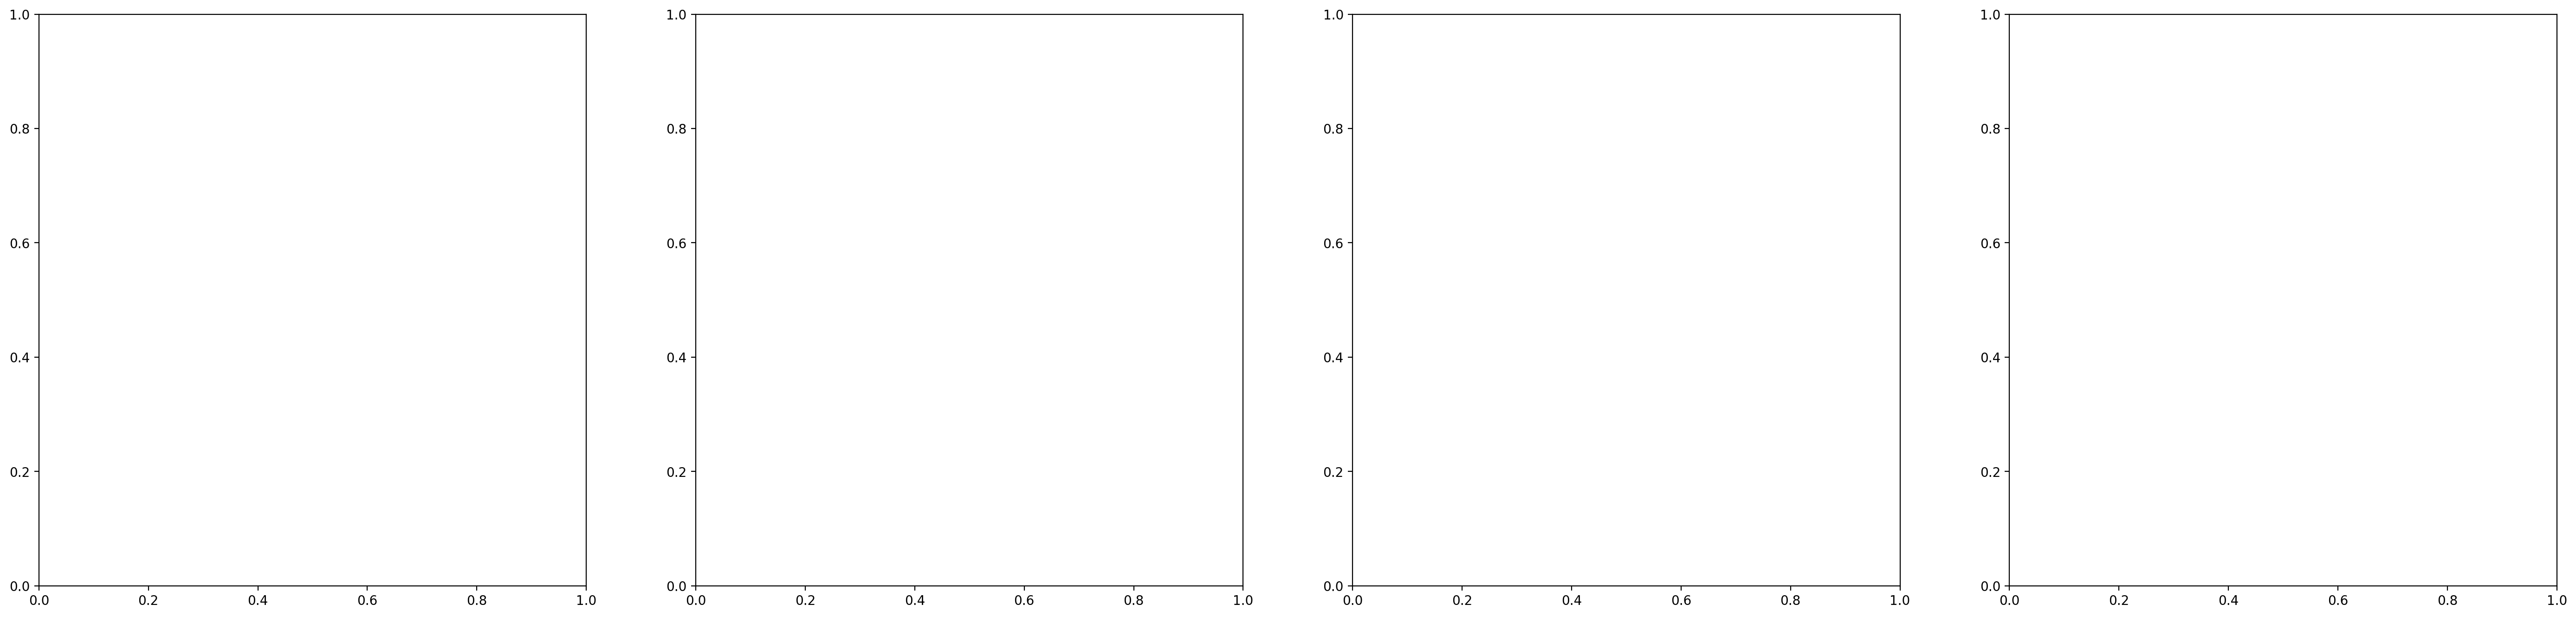

In [145]:
fig,ax=plt.subplots(nrows=1,ncols=4,dpi=200,figsize=[35,8])
ax[0].plot(Q, train_accuracies__ft, color='red', label='Train Accuracy ',zorder=3)
ax[0].plot(Q, test_accuracies__ft, color='green', label='Test Accuracy',zorder=3)
ax[0].plot(Q,test_accuracies__ft_plus, color=U[0], label='Modular addition Accuracy' )
ax[0].legend()
ax[0].set_xlabel("Numbers of Epochs")
ax[0].set_xlim(1, 1.50*10**4)
ax[0].set_ylabel("Accuracies")
#plt.xscale('log')
ax[0].legend(loc=(0.015, 0.72))
ax[0].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=1", fontsize=11)

ax[1].plot(Q, train_accuracies__ft4, color='red', label='Train Accuracy ',zorder=3)
ax[1].plot(Q, test_accuracies__ft4, color='green', label='Test Accuracy',zorder=3)
ax[1].plot(Q,test_accuracies__ft_plus4, color=U[0], label='Modular addition Accuracy' )
ax[1].legend()
ax[1].set_xlabel("Numbers of Epochs")
ax[1].set_xlim(1, 1.50*10**4)
ax[1].set_ylabel("Accuracies")
ax[1].legend(loc=(0.015, 0.72))
ax[1].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=4", fontsize=11)

ax[2].plot(log_steps_2, train_accuracies__ft8, color='red', label='Train Accuracy ',zorder=3)
ax[2].plot(log_steps_2, test_accuracies__ft8, color='green', label='Test Accuracy',zorder=3)
ax[2].plot(log_steps_2,test_accuracies__ft_plus8, color=U[0], label='Modular addition Accuracy' )
ax[2].legend()
ax[2].set_xlabel("Numbers of Epochs")
ax[2].set_xlim(1, 2.0*10**4)
ax[2].set_ylabel("Accuracies")
ax[2].legend(loc=(0.015, 0.72))
ax[2].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=8", fontsize=11)

ax[3].plot(Q, train_accuracies__ft2, color='red', label='Train Accuracy ',zorder=3)
ax[3].plot(Q, test_accuracies__ft2, color='green', label='Test Accuracy',zorder=3)
ax[3].plot(Q,test_accuracies__ft_plus2, color=U[0], label='Modular addition Accuracy' )
ax[3].legend()
ax[3].set_xlabel("Numbers of Epochs")
ax[3].set_xlim(1, 1.50*10**4)
ax[3].set_ylabel("Accuracies")
#plt.xscale('log')
ax[3].legend(loc=(0.015, 0.72))
ax[3].set_title("2L Full-finetuning on Modular Subtraction (p=113) r=16", fontsize=11)

### Hyperparameters of the training r=16

In [ ]:
config = peft.LoraConfig(
    r=16,
    target_modules=[  "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix","blocks.1.attn.key_matrix", "blocks.1.attn.query_matrix","blocks.1.attn.value_matrix","blocks.2.attn.key_matrix", "blocks.2.attn.query_matrix","blocks.2.attn.value_matrix"]
)
lr=10e-3
model = model_4.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
#model=peft_model
epochs=10000
train = data_train
test = data_test
log_steps = []
train_losses__ft_4_16 = []
test_losses__ft_4_16= []
train_accuracies__ft_4_16 = []
test_accuracies__ft_4_16 = []
test_accuracies__ft_plus_4_16 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus_4_16.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft_4_16.append(train_loss.item())
            test_losses__ft_4_16.append(test_loss__1.item())
            train_accuracies__ft_4_16.append(full_accuracy(model, train, device))
            test_accuracies__ft_4_16.append(full_accuracy(model, test, device))
            #norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | Test_mod_add: %.6f  "%(epoch, train_losses__ft_4_16[-1], test_losses__ft_4_16[-1], train_accuracies__ft_4_16[-1], test_accuracies__ft_4_16[-1], test_accuracies__ft_plus_4_16[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


In [150]:
model.parameters

<bound method Module.parameters of Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (query_matrix): lora.Linear(
          (base_layer): Linear(in_features=128, out_features=128, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=128, out_features=1, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=1, out_features=128, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
        )
        (key_matrix): lora.Linear(
          (base_layer): Linear(in_features=128, out_features=128, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): 

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

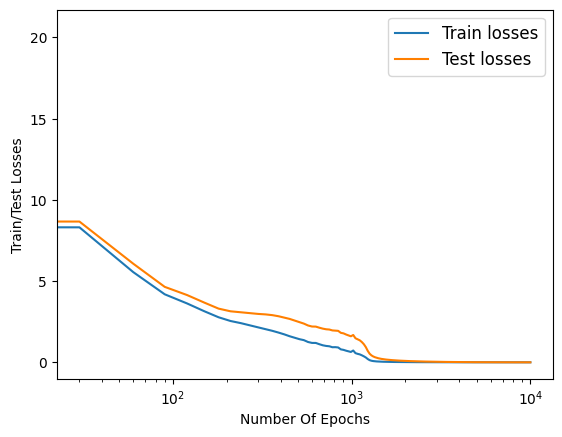

In [146]:
plt.figure
plt.plot(log_steps,train_losses__ft_4_16, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft_4_16, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

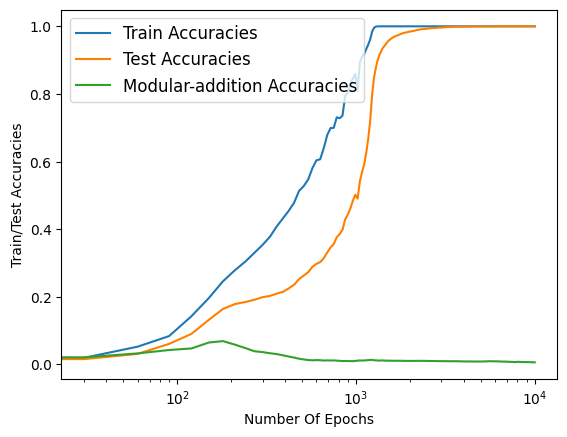

In [147]:
plt.figure
plt.plot(log_steps,train_accuracies__ft_4_16 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft_4_16, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus_4_16, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()

#### Scalar products etc

#### Vizualizing dynamics

### Hyperparameters of the training r=32

In [ ]:
config = peft.LoraConfig(
    r=32,
    target_modules=[ "blocks.0.attn.key_matrix", "blocks.0.attn.query_matrix","blocks.0.attn.value_matrix"]
)
lr=10e-3
model = model.to(device)
model_copy = copy.deepcopy(model)  # we keep a copy of the original model for later
peft_model = peft.get_peft_model(model, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
peft_model.print_trainable_parameters()

In [ ]:
lr=1e-3
wd=0.
epochs=15000

In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
minus = torch.ones(x.shape, dtype=torch.int64) * (equals_token+2)
prompts = torch.stack([x, minus, y, equals], dim=1).to(device)
answers = ((x - y) % p).to(device)

equals_token = p
x_plus, y_plus = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x_plus = x.flatten()
y_plus = y.flatten()
equals_plus = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts_plus = torch.stack([x, plus, y, equals], dim=1).to(device)
answers_plus = ((x + y) % p).to(device)
fraction=0.3

data = torch.utils.data.TensorDataset(prompts, answers)
data_train, data_test = torch.utils.data.random_split(data,
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

data_plus = torch.utils.data.TensorDataset(prompts_plus, answers_plus)
fraction=0.
data_train_plus, data_test_plus = torch.utils.data.random_split(data_plus,
                                [0,
                                len(data)
                                ])

In [ ]:
epochs=10000
train = data_train
test = data_test
Attn_wk_ft32= []
Attn_wq_ft32= []
Attn_wv_ft32=[]
Attn_wo_ft32=[]
log_steps = []
train_losses__ft32 = []
test_losses__ft32= []
train_accuracies__ft32 = []
test_accuracies__ft32 = []
test_accuracies__ft_plus32 = []
norms = []
for epoch in tqdm(range(epochs)):
  train_loss = full_loss(model, train, device)
  if epoch % 30 == 0:
    for param_tensor in model.state_dict():
          if param_tensor=='blocks.0.attn.key_matrix.weight':
            Attn_wk_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.query_matrix.weight':
            Attn_wq_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
          if param_tensor=='blocks.0.attn.value_matrix.weight':
            Attn_wv_ft32.append(model.state_dict()[param_tensor].cpu().detach().numpy())
    with torch.no_grad():
            log_steps.append(epoch)
            test_accuracies__ft_plus32.append(full_accuracy(model, data_test_plus, device))
            test_loss__1 = full_loss(model, test, device)
            test_2,train_2=test_loss__1.item(),train_loss.item()
            train_losses__ft32.append(train_loss.item())
            test_losses__ft32.append(test_loss__1.item())
            train_accuracies__ft32.append(full_accuracy(model, train, device))
            test_accuracies__ft32.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
            print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f | Test_mod_add: %.6f  "%(epoch, train_losses__ft32[-1], test_losses__ft32[-1], train_accuracies__ft32[-1], test_accuracies__ft32[-1], norms[-1],test_accuracies__ft_plus32[-1]))

  train_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    # Print model's state_dict# print("Model's state_dict:")


In [ ]:
wk_32= [Attn_wk_ft32[i] for i in range(len(Attn_wk_ft32))]
wq_32= [Attn_wq_ft32[i] for i in range(len(Attn_wq_ft32))]
wv_32= [(Attn_wv_ft32[i]) for i in range(len(Attn_wv_ft32))]

In [ ]:
spv=[np.linalg.eigvals(x) for x in wv ]

In [ ]:
spq=[np.linalg.eigvals(x) for x in wq ]
spk=[np.linalg.eigvals(x) for x in wk]

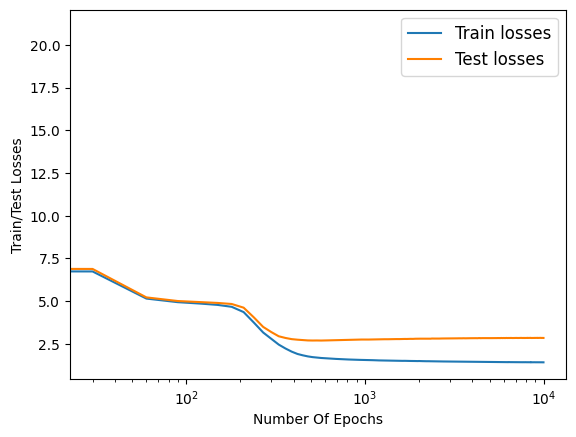

In [148]:
plt.figure
plt.plot(log_steps,train_losses__ft32, color=Z[1],label='Train losses')
plt.plot(log_steps,test_losses__ft32, color=Z[7],label='Test losses')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Losses')
plt.xscale('log')
plt.show()

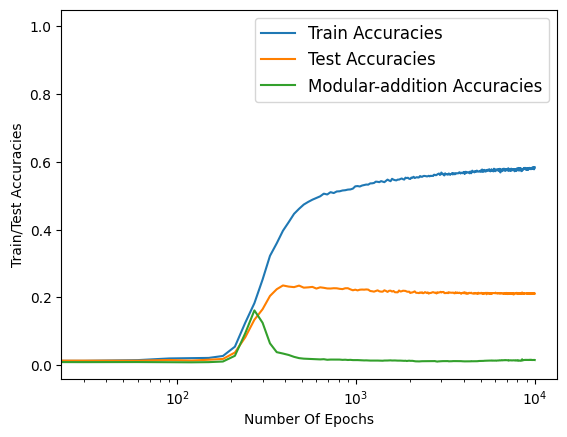

In [149]:
plt.figure
plt.plot(log_steps,train_accuracies__ft32 , color=Z[1],label='Train Accuracies')
plt.plot(log_steps,test_accuracies__ft32, color=Z[7],label='Test Accuracies')
plt.plot(log_steps,test_accuracies__ft_plus32, color=Z[3],label='Modular-addition Accuracies')
plt.legend(fontsize='large')
plt.xlabel('Number Of Epochs')
plt.ylabel('Train/Test Accuracies')
plt.xscale('log')
plt.show()